In [ ]:
!pip install rdkit catboost
!python -m pip install git+https://github.com/EBjerrum/molvecgen

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 1.9 MB/s eta 0:00:00
  Cloning https://github.com/EBjerrum/molvecgen to /tmp/pip-req-build-5wihfkc5
  Running command git clone --filter=blob:none --quiet https://github.com/EBjerrum/molvecgen /tmp/pip-req-build-5wihfkc5
  Resolved https://github.com/EBjerrum/molvecgen to commit f81d5aade18bea60882f5845877f6283366bbe91
  Preparing metadata (setup.py) ... done
  Created wheel for molvecgen: filename=molvecgen-0.1-py3-none-any.whl size=11356 sha256=1e2e613e73fbde35a1439d1af1e57df0418f94c35f50fe917b411dec9b5b6bc0
  Stored in directory: /tmp/pip-ephem-wheel-cache-6o0emly3/wheels/1c/de/14/fd9892b48271e63e56b00c7015c754ae6189e258fa313a7c63
Successfully built molvecgen


In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem, Draw, Descriptors
from rdkit.Chem.Draw import IPythonConsole
from sklearn.preprocessing import FunctionTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import cross_val_score
from molvecgen.vectorizers import SmilesVectorizer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_excel('/content/drive/MyDrive/ml/19_35000.xlsx')
df.head()

,Unnamed: 0,Title,IC50,SMILES
0,NaN,CHEMBL2206459,0.000015,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...
1,NaN,CHEMBL3818159,0.000016,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...
2,NaN,CHEMBL1956716,0.000033,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...
3,NaN,CHEMBL1956715,0.000032,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...
4,NaN,CHEMBL4444029,0.000041,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...


In [ ]:
df = df.iloc[:, 1:]
df = df.loc[df['Title'] != '#REF!']
df = df.loc[df['SMILES'] != '#REF!']
df.describe()

,IC50
count,36377.000000
mean,7.813503
std,48.489710
min,0.000010
25%,1.696000
50%,3.635000
75%,5.934000
max,3183.600000


In [ ]:
df

,Title,IC50,SMILES
0,CHEMBL2206459,0.000015,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...
1,CHEMBL3818159,0.000016,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...
2,CHEMBL1956716,0.000033,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...
3,CHEMBL1956715,0.000032,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...
4,CHEMBL4444029,0.000041,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...
...,...,...,...
36372,CHEMBL3699085,2366.790000,CC(=O)N[C@H]1CC[C@@H]([C@@H]12)[C@@H](O[Si](C)...
36373,CHEMBL109004,2372.100000,CC(=O)Nc(cc1)c(OC(=O)C)cc1C(=O)O
36374,CHEMBL2259758,2600.970000,c1cccc(c12)cccc2CNC(=O)CCCCCCO[C@]3(C(=O)O)C[C...
36375,CHEMBL109781,2793.000000,NCCCC(=O)Nc(c(cc1)NC(=O)C)cc1C(=O)O


In [ ]:
duplicates_count = df.duplicated(subset='SMILES').sum()
print(duplicates_count)
df.drop_duplicates(subset='SMILES', inplace=True)

117


In [ ]:
df

,Title,IC50,SMILES
0,CHEMBL2206459,0.000015,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...
1,CHEMBL3818159,0.000016,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...
2,CHEMBL1956716,0.000033,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...
3,CHEMBL1956715,0.000032,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...
4,CHEMBL4444029,0.000041,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...
...,...,...,...
36372,CHEMBL3699085,2366.790000,CC(=O)N[C@H]1CC[C@@H]([C@@H]12)[C@@H](O[Si](C)...
36373,CHEMBL109004,2372.100000,CC(=O)Nc(cc1)c(OC(=O)C)cc1C(=O)O
36374,CHEMBL2259758,2600.970000,c1cccc(c12)cccc2CNC(=O)CCCCCCO[C@]3(C(=O)O)C[C...
36375,CHEMBL109781,2793.000000,NCCCC(=O)Nc(c(cc1)NC(=O)C)cc1C(=O)O


(array([5.8330e+03, 2.5615e+04, 4.2490e+03, 3.2600e+02, 8.6000e+01,
        4.6000e+01, 4.4000e+01, 1.7000e+01, 4.0000e+01, 4.0000e+00]),
 array([  7. ,  34.4,  61.8,  89.2, 116.6, 144. , 171.4, 198.8, 226.2,
        253.6, 281. ]),
 <BarContainer object of 10 artists>)

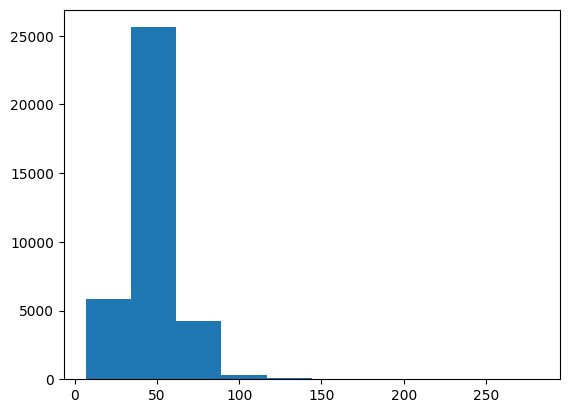

In [ ]:
df['S_leng'] = df['SMILES'].str.len ()
plt.hist(df['S_leng'])

In [ ]:

def remove_outliers_iqr(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_filtered = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    return df_filtered

(array([  39.,  401., 2854., 6870., 8008., 7821., 4955., 2652., 1234.,
         623.]),
 array([10. , 17.2, 24.4, 31.6, 38.8, 46. , 53.2, 60.4, 67.6, 74.8, 82. ]),
 <BarContainer object of 10 artists>)

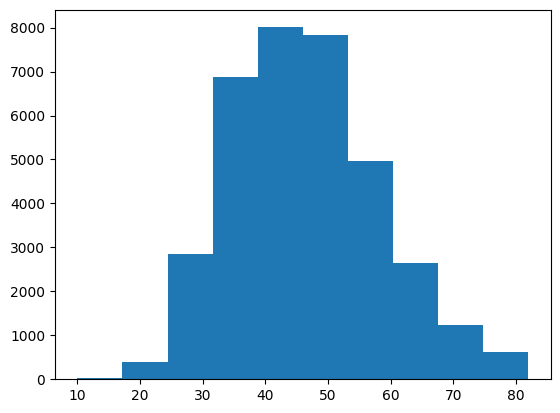

In [ ]:

df = remove_outliers_iqr(df, 'S_leng')
plt.hist(df['S_leng'])

In [ ]:

def mol_dsc_calc(mols):
    return pd.DataFrame({k: f(Chem.MolFromSmiles(m)) for k, f in descriptors.items()} for m in mols)

descriptors = {"HeavyAtomCount": Descriptors.HeavyAtomCount,
               "NHOHCount": Descriptors.NHOHCount,
               "NOCount": Descriptors.NOCount,
               "NumHAcceptors": Descriptors.NumHAcceptors,
               "NumHDonors": Descriptors.NumHDonors,
               "NumHeteroatoms": Descriptors.NumHeteroatoms,
               "NumRotatableBonds": Descriptors.NumRotatableBonds,
               "NumValenceElectrons": Descriptors.NumValenceElectrons,
               "NumAromaticRings": Descriptors.NumAromaticRings,
               "NumAliphaticHeterocycles": Descriptors.NumAliphaticHeterocycles,
               "RingCount": Descriptors.RingCount,
               "MW": Descriptors.MolWt,
               "LogP": Descriptors.MolLogP,
               "MR": Descriptors.MolMR,
               "TPSA": Descriptors.TPSA}

In [ ]:
df_v = df[['IC50']]
y = df_v['IC50'].values.reshape((-1,1))

In [ ]:

df = df.reset_index(drop = True)
result_df = df

In [ ]:
result_df

,Title,IC50,SMILES,S_leng
0,CHEMBL2206459,0.000015,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...,66
1,CHEMBL3818159,0.000016,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...,52
2,CHEMBL1956716,0.000033,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...,55
3,CHEMBL1956715,0.000032,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...,53
4,CHEMBL4444029,0.000041,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...,55
...,...,...,...,...
35452,CHEMBL1145,1951.700000,CC(=O)Nc(cc1)c(O)cc1C(=O)O,26
35453,CHEMBL109005,2101.900000,CC(=O)Nc(c(c1)O)c(N)cc1C(=O)O,29
35454,CHEMBL109004,2372.100000,CC(=O)Nc(cc1)c(OC(=O)C)cc1C(=O)O,32
35455,CHEMBL109781,2793.000000,NCCCC(=O)Nc(c(cc1)NC(=O)C)cc1C(=O)O,35


In [ ]:

descriptors_transformer = FunctionTransformer(mol_dsc_calc)
X_descr = descriptors_transformer.transform(df['SMILES'])

result_df = pd.concat([result_df, X_descr], axis=1)

In [ ]:
result_df = result_df.drop(columns = ['IC50','Title', 'SMILES'])
result_df.head()

,S_leng,HeavyAtomCount,NHOHCount,NOCount,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumAliphaticHeterocycles,RingCount,MW,LogP,MR,TPSA
0,66,24,7,9,4,6,10,7,138,0,0,1,362.367,0.38187,90.4296,157.76
1,52,21,4,6,4,3,6,7,120,0,0,1,298.383,1.05450,79.7279,101.65
2,55,21,3,6,5,2,6,7,118,0,0,1,295.359,-0.36170,77.0531,104.48
3,53,20,3,6,5,2,6,6,114,0,0,1,283.348,-0.52780,72.5301,104.48
4,55,24,4,9,6,4,9,3,122,3,0,3,329.268,1.09742,81.9775,149.28


In [ ]:

scaler = StandardScaler()
y = scaler.fit_transform(y)

In [ ]:
y

array([[-0.16624178],
       [-0.16624175],
       [-0.16624134],
       ...,
       [55.51475552],
       [65.39466442],
       [74.56333256]])

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(result_df, y, test_size=0.2, random_state=42)

In [ ]:
cat_model = CatBoostRegressor(verbose = 500)

In [ ]:

cat_model.fit(X_train, y_train)

Learning rate set to 0.069458
0:	learn: 0.9595686	total: 6.06ms	remaining: 6.06s
500:	learn: 0.4986511	total: 2.7s	remaining: 2.69s
999:	learn: 0.3801934	total: 5.4s	remaining: 0us


In [ ]:

y_pred = cat_model.predict(X_test)

In [ ]:

from sklearn.metrics import r2_score
# Calculate R^2 score for the predicted values
r2 = r2_score(y_test, y_pred)
print('R^2 score:', r2)

R^2 score: 0.0910958261613467


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score

In [ ]:
X_train_str = X_train

In [ ]:
X_train_str.columns = X_train_str.columns.astype(str)

In [ ]:
X_test_str = X_test

In [ ]:
X_test_str.columns = X_test_str.columns.astype(str)

In [ ]:

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

In [ ]:

rf_model.fit(X_train_str, y_train)


<ipython-input-84-37a8f244c56f>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train_str, y_train)


RandomForestRegressor(random_state=42)

In [ ]:

rf_predictions = rf_model.predict(X_test)

rf_r2 = r2_score(y_test, rf_predictions)
print("Random Forest Regression R^2 score:", rf_r2)

Random Forest Regression R^2 score: 0.08517682648582059


In [ ]:

svr_model = SVR(kernel='rbf', C=1, epsilon=0.2)

In [ ]:

svr_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1, epsilon=0.2)

In [ ]:

svr_predictions = svr_model.predict(X_test)

svr_r2 = r2_score(y_test, svr_predictions)
print("SVR R^2 score:", svr_r2)

SVR R^2 score: -0.0004354769591377039


In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

elastic_net_model = ElasticNet(alpha=0.1, l1_ratio=0.5)


In [ ]:

elastic_net_model.fit(X_train, y_train)

ElasticNet(alpha=0.1)

In [ ]:

elastic_net_predictions = elastic_net_model.predict(X_test)

elastic_net_r2 = r2_score(y_test, elastic_net_predictions)
print("Elastic Net Regression R^2 score:", elastic_net_r2)

Elastic Net Regression R^2 score: 0.003256682259896615


In [ ]:

decision_tree_model = DecisionTreeRegressor(random_state=42)

In [ ]:

decision_tree_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [ ]:

decision_tree_predictions = decision_tree_model.predict(X_test)

decision_tree_r2 = r2_score(y_test, decision_tree_predictions)
print("Decision Tree Regressor R^2 score:", decision_tree_r2)

Decision Tree Regressor R^2 score: -0.7273279909637973
